### Neural Collaborative Filtering
- https://arxiv.org/pdf/1708.05031v2.pdf


- Official NCF implementation [Keras with Theano]: https://github.com/hexiangnan/neural_collaborative_filtering

In [86]:
!pip install tf_slim
!pip install gdown
!pip install --upgrade --no-cache-dir gdown
!pip install recommenders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [87]:
import warnings
warnings.filterwarnings("ignore")

In [88]:
from datetime import datetime
import os
import matplotlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

from scipy import sparse
from scipy.sparse import csc_matrix
from sklearn.decomposition import TruncatedSVD
import random
random.seed(0)
np.random.seed(0)

In [89]:

from datetime import datetime, timedelta

from recommenders.datasets.python_splitters import (
    python_chrono_split
   
)

In [90]:
SEED = 42
np.random.seed(SEED)

## Analyse Dataset

### Book  Dataset
https://www.kaggle.com/datasets/arashnic/book-recommendation-dataset


In [91]:
rating_df = pd.read_csv('Ratings.csv')
users_df = pd.read_csv('Users.csv')
book_df = pd.read_csv('Books.csv')

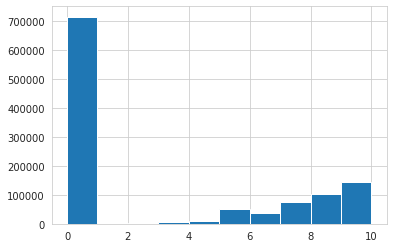

In [92]:
rating_df=pd.merge(rating_df,book_df,on="ISBN",how="left")
rating_df=pd.merge(rating_df,users_df,on="User-ID",how="left")
rating_df['Book-Rating'].hist()

In [93]:
rating_df=rating_df[rating_df['Book-Rating']>2]

In [94]:
y = rating_df.groupby('Book-Title').count()['Book-Rating']>=30
books = y[y].index

In [95]:
rating_df = rating_df[rating_df['Book-Title'].isin(books)]
rating_df.shape

(89113, 12)

In [96]:
x = rating_df.groupby('User-ID').count()['Book-Rating'] >= 30
userIndex = x[x].index
rating_df=rating_df[rating_df['User-ID'].isin(userIndex)]

In [97]:
rating_df.rename(columns = {'User-ID':'userID', 'Book-Title':'itemID','Book-Rating':'rating'}, inplace = True)

In [98]:
final_ratings=rating_df

In [99]:
unique_users = rating_df.userID.unique()
user_ids = dict(zip(unique_users, np.arange(unique_users.shape[0], dtype=np.int32)))

unique_items = rating_df.itemID.unique()
item_ids = dict(zip(unique_items, np.arange(unique_items.shape[0], dtype=np.int32)))

In [100]:
product_ids = list(set(list(rating_df.itemID.unique())))
user_ids = list(set(list(rating_df.userID.unique())))

In [101]:
dict_products = {}
index = 0
for ids in sorted(product_ids):
    dict_products[ids] = index
    index += 1

In [102]:
dict_users = {}
index = 0
for ids in sorted(user_ids):
    dict_users[ids] = index
    index += 1

### Prepare train test set

In [103]:
rating_df["itemID"] = rating_df["itemID"].map(dict_products)
rating_df["userID"] = rating_df["userID"].map(dict_users)

In [104]:
test_df=final_ratings.groupby('userID').head(10)
test_df.shape

(3080, 12)

In [105]:
final_ratings=final_ratings[~final_ratings.isin(test_df).all(1)]
final_ratings.shape

(13332, 12)

In [106]:
train_df=final_ratings

In [107]:
test_df = test_df[test_df["userID"].isin(train_df["userID"].unique())]
test_df = test_df[test_df["itemID"].isin(train_df["itemID"].unique())]

In [108]:
test_df.head(1)

,userID,ISBN,rating,itemID,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,Location,Age
20752,0,006000438X,10,936,Manil Suri,2002,Perennial,http://images.amazon.com/images/P/006000438X.0...,http://images.amazon.com/images/P/006000438X.0...,http://images.amazon.com/images/P/006000438X.0...,"new orleans, louisiana, usa",48.0


In [109]:
train_file = "./train.csv"
test_file = "./test.csv"
train_df.to_csv(train_file, index=False)
test_df.to_csv(test_file, index=False)


### Use NCF using recommenders

In [110]:
import tensorflow as tf
from recommenders.utils.timer import Timer
from recommenders.models.ncf.ncf_singlenode import NCF
from recommenders.models.ncf.dataset import Dataset as NCFDataset
from recommenders.datasets import movielens
from recommenders.utils.notebook_utils import is_jupyter
from recommenders.datasets.python_splitters import python_chrono_split
from recommenders.evaluation.python_evaluation import (rmse, mae, rsquared, exp_var, map_at_k, ndcg_at_k, precision_at_k, 
                                                     recall_at_k, get_top_k_items)

In [111]:
data = NCFDataset(train_file=train_file, test_file=test_file, seed=SEED, overwrite_test_file_full=True)

INFO:recommenders.models.ncf.dataset:Indexing ./train.csv ...
INFO:recommenders.models.ncf.dataset:Indexing ./test.csv ...
INFO:recommenders.models.ncf.dataset:Creating full leave-one-out test file ./test_full.csv ...
100%|██████████| 308/308 [00:07<00:00, 39.20it/s]
INFO:recommenders.models.ncf.dataset:Indexing ./test_full.csv ...


Train NeuMF based on TensorFlow

In [112]:
EPOCHS=40
BATCH=256
LAYER=[512,256,32]
LR=1e-3
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=LAYER,
    n_epochs=EPOCHS,
    batch_size=BATCH,
    learning_rate=LR,
    verbose=10,
    seed=SEED
)

In [113]:
with Timer() as timer:
    model.fit(data)

print("Took {} seconds for training.".format(timer.interval))

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [1.71s]: train_loss = 0.309910 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [1.66s]: train_loss = 0.149536 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [1.66s]: train_loss = 0.071304 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [1.64s]: train_loss = 0.043717 


Took 68.33415680600046 seconds for training.


In [114]:
predictions = [[row.userID, row.itemID, model.predict(row.userID, row.itemID)]
               for (_, row) in test_df.iterrows()]


predictions = pd.DataFrame(predictions, columns=['userID', 'itemID', 'prediction'])
predictions.head(5)

,userID,itemID,prediction
0,0,936,2.916416e-09
1,0,1103,8.355610e-10
2,0,526,6.074494e-25
3,0,875,7.906395e-09
4,0,157,4.194751e-15


### Evaluation

In [115]:
with Timer() as test_time:

    users, items, preds = [], [], []
    item = list(train_df.itemID.unique())
    for user in train_df.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train_df, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time.interval))

Took 1.1210536139997203 seconds for prediction.


In [116]:
TOP_K=20
eval_map = map_at_k(test_df, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test_df, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test_df, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.006260
Precision@K:	0.012175
Recall@K:	0.024603


In [117]:
k = 20

ndcgs = []
hit_ratio = []

for b in data.test_loader():
    user_input, item_input, labels = b
    output = model.predict(user_input, item_input, is_list=True)

    output = np.squeeze(output)
    rank = sum(output >= output[0])
    if rank <= k:
        ndcgs.append(1 / np.log(rank + 1))
        hit_ratio.append(1)
    else:
        ndcgs.append(0)
        hit_ratio.append(0)

eval_ndcg = np.mean(ndcgs)
eval_hr = np.mean(hit_ratio)

print("Hit Rate:\t%f" % eval_hr)
print("Normalized Discounted Cumulative Gain :\t%f" % eval_ndcg)

Hit Rate:	0.469035
Normalized Discounted Cumulative Gain :	0.479197


### Combine GMF and MLP

In [118]:
EPOCHS=40
BATCH=256
LAYER=[512,256,32]
LR=1e-3
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="GMF",
    n_factors=4,
    layer_sizes=LAYER,
    n_epochs=EPOCHS,
    batch_size=BATCH,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

In [119]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time.interval))

model.save(dir_name=".pretrain/GMF")

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [1.41s]: train_loss = 0.459158 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [1.38s]: train_loss = 0.453227 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [1.38s]: train_loss = 0.429409 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [1.37s]: train_loss = 0.398381 


Took 56.35251128799973 seconds for training.


In [120]:

EPOCHS=40
BATCH=256
LAYER=[512,256,32]
LR=1e-3
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="MLP",
    n_factors=4,
    layer_sizes=LAYER,
    n_epochs=EPOCHS,
    batch_size=BATCH,
    learning_rate=1e-3,
    verbose=10,
    seed=SEED
)

In [121]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time.interval))

model.save(dir_name=".pretrain/MLP")

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [1.41s]: train_loss = 0.338722 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [1.67s]: train_loss = 0.175746 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [1.42s]: train_loss = 0.086335 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [1.41s]: train_loss = 0.053900 


Took 58.234696630000144 seconds for training.


In [122]:
EPOCHS=40
BATCH=256
LAYER=[512,256,32]
LR=1e-3
model = NCF (
    n_users=data.n_users, 
    n_items=data.n_items,
    model_type="NeuMF",
    n_factors=4,
    layer_sizes=LAYER,
    n_epochs=EPOCHS,
    batch_size=BATCH,
    learning_rate=LR,
    verbose=10,
    seed=SEED
)
model.load(gmf_dir=".pretrain/GMF", mlp_dir=".pretrain/MLP", alpha=0.5)

INFO:tensorflow:Restoring parameters from .pretrain/GMF/model.ckpt


INFO:tensorflow:Restoring parameters from .pretrain/GMF/model.ckpt


INFO:tensorflow:Restoring parameters from .pretrain/MLP/model.ckpt


INFO:tensorflow:Restoring parameters from .pretrain/MLP/model.ckpt


In [123]:
with Timer() as train_time:
    model.fit(data)

print("Took {} seconds for training.".format(train_time.interval))

INFO:recommenders.models.ncf.ncf_singlenode:Epoch 10 [1.66s]: train_loss = 0.041814 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 20 [1.65s]: train_loss = 0.030895 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 30 [2.21s]: train_loss = 0.021100 
INFO:recommenders.models.ncf.ncf_singlenode:Epoch 40 [1.66s]: train_loss = 0.020011 


Took 71.4493417119993 seconds for training.


In [124]:
with Timer() as test_time:

    users, items, preds = [], [], []
    item = list(train_df.itemID.unique())
    for user in train_df.userID.unique():
        user = [user] * len(item) 
        users.extend(user)
        items.extend(item)
        preds.extend(list(model.predict(user, item, is_list=True)))

    all_predictions = pd.DataFrame(data={"userID": users, "itemID":items, "prediction":preds})

    merged = pd.merge(train_df, all_predictions, on=["userID", "itemID"], how="outer")
    all_predictions = merged[merged.rating.isnull()].drop('rating', axis=1)

print("Took {} seconds for prediction.".format(test_time.interval))

Took 1.1178595559995301 seconds for prediction.


In [125]:
TOP_K=20
eval_map = map_at_k(test_df, all_predictions, col_prediction='prediction', k=TOP_K)
eval_precision = precision_at_k(test_df, all_predictions, col_prediction='prediction', k=TOP_K)
eval_recall = recall_at_k(test_df, all_predictions, col_prediction='prediction', k=TOP_K)

print("MAP:\t%f" % eval_map,
      "Precision@K:\t%f" % eval_precision,
      "Recall@K:\t%f" % eval_recall, sep='\n')

MAP:	0.005344
Precision@K:	0.012662
Recall@K:	0.025541


In [126]:
k = 20

ndcgs = []
hit_ratio = []

for b in data.test_loader():
    user_input, item_input, labels = b
    output = model.predict(user_input, item_input, is_list=True)

    output = np.squeeze(output)
    rank = sum(output >= output[0])
    if rank <= k:
        ndcgs.append(1 / np.log(rank + 1))
        hit_ratio.append(1)
    else:
        ndcgs.append(0)
        hit_ratio.append(0)

eval_ndcg = np.mean(ndcgs)
eval_hr = np.mean(hit_ratio)

print("Hit Rate:\t%f" % eval_hr)
print("Normalized Discounted Cumulative Gain :\t%f" % eval_ndcg)

Hit Rate:	0.484029
Normalized Discounted Cumulative Gain :	0.497668
